In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm

In [3]:
df = pd.read_csv("./results/runtime_comparison_8-4096.csv")

In [4]:
df

,type,num_otus,ID,our_time,ete_time
0,balanced,8,0,0.000050,0.000149
1,pectinate_right,8,0,0.000030,0.000136
2,random,8,0,0.000031,0.000129
3,balanced,8,1,0.000032,0.001123
4,pectinate_right,8,1,0.000057,0.000144
...,...,...,...,...,...
29995,pectinate_right,4096,998,0.658582,15.680878
29996,random,4096,998,0.075004,6.583184
29997,balanced,4096,999,0.035170,7.502626
29998,pectinate_right,4096,999,0.761564,15.602800


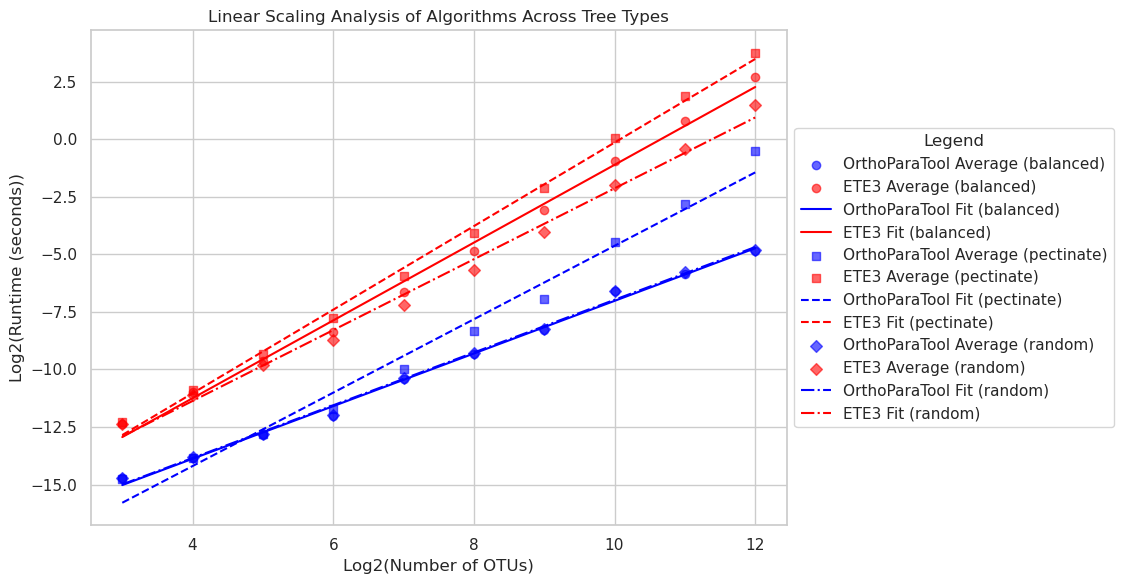

In [9]:
# Log2-transformations
df['log2_num_otus'] = np.log2(df['num_otus'])
df['log2_our_time'] = np.log2(df['our_time'])
df['log2_ete_time'] = np.log2(df['ete_time'])

# Group by both type and number of OTUs, and calculate mean
df_grouped = df.groupby(['type', 'num_otus']).agg({
    'log2_our_time': 'mean',
    'log2_ete_time': 'mean',
    'log2_num_otus': 'mean'
}).reset_index()

# Linear regression given dataframe
def linear_regression(df, time_column):
    X = sm.add_constant(df['log2_num_otus'])
    y = df[time_column]
    model = sm.OLS(y, X).fit()
    return model

# Style
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

markers = {'balanced': 'o', 'pectinate_right': 's', 'random': 'D'}
line_styles = {'balanced': '-', 'pectinate_right': '--', 'random': '-.'}

colors = {'ortho_param_tool': 'blue', 'ete3': 'red'}

for tree_type in df_grouped['type'].unique():
    df_subset = df_grouped[df_grouped['type'] == tree_type]

    # Fit linear models for both algorithms
    model_our = linear_regression(df_subset, 'log2_our_time')
    model_ete = linear_regression(df_subset, 'log2_ete_time')

    # Linear fit values
    x_vals = np.linspace(df_subset['log2_num_otus'].min(), df_subset['log2_num_otus'].max(), 100)
    X_pred = sm.add_constant(x_vals)
    y_our_pred = model_our.predict(X_pred)
    y_ete_pred = model_ete.predict(X_pred)

    # Define the label for the tree type
    tree_label = 'pectinate' if tree_type == 'pectinate_right' else tree_type

    # Plot averages by algorithm, tree type, and number of OTUs
    plt.scatter(df_subset['log2_num_otus'], df_subset['log2_our_time'], 
                label=f'OrthoParaTool Average ({tree_label})', color=colors['ortho_param_tool'], 
                marker=markers[tree_type], alpha=0.6)
    plt.scatter(df_subset['log2_num_otus'], df_subset['log2_ete_time'], 
                label=f'ETE3 Average ({tree_label})', color=colors['ete3'], 
                marker=markers[tree_type], alpha=0.6)

    # Plot linear fit
    plt.plot(x_vals, y_our_pred, label=f'OrthoParaTool Fit ({tree_label})', 
             color=colors['ortho_param_tool'], linestyle=line_styles[tree_type])
    plt.plot(x_vals, y_ete_pred, label=f'ETE3 Fit ({tree_label})', 
             color=colors['ete3'], linestyle=line_styles[tree_type])


# Title, labels, and legend

plt.title('Linear Scaling Analysis of Algorithms Across Tree Types')
plt.xlabel('Log2(Number of OTUs)')
plt.ylabel('Log2(Runtime (seconds))')


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Legend')

plt.tight_layout(rect=[0, 0, 0.95, 1])  # Adjust layout to make space for the legend
plt.show()


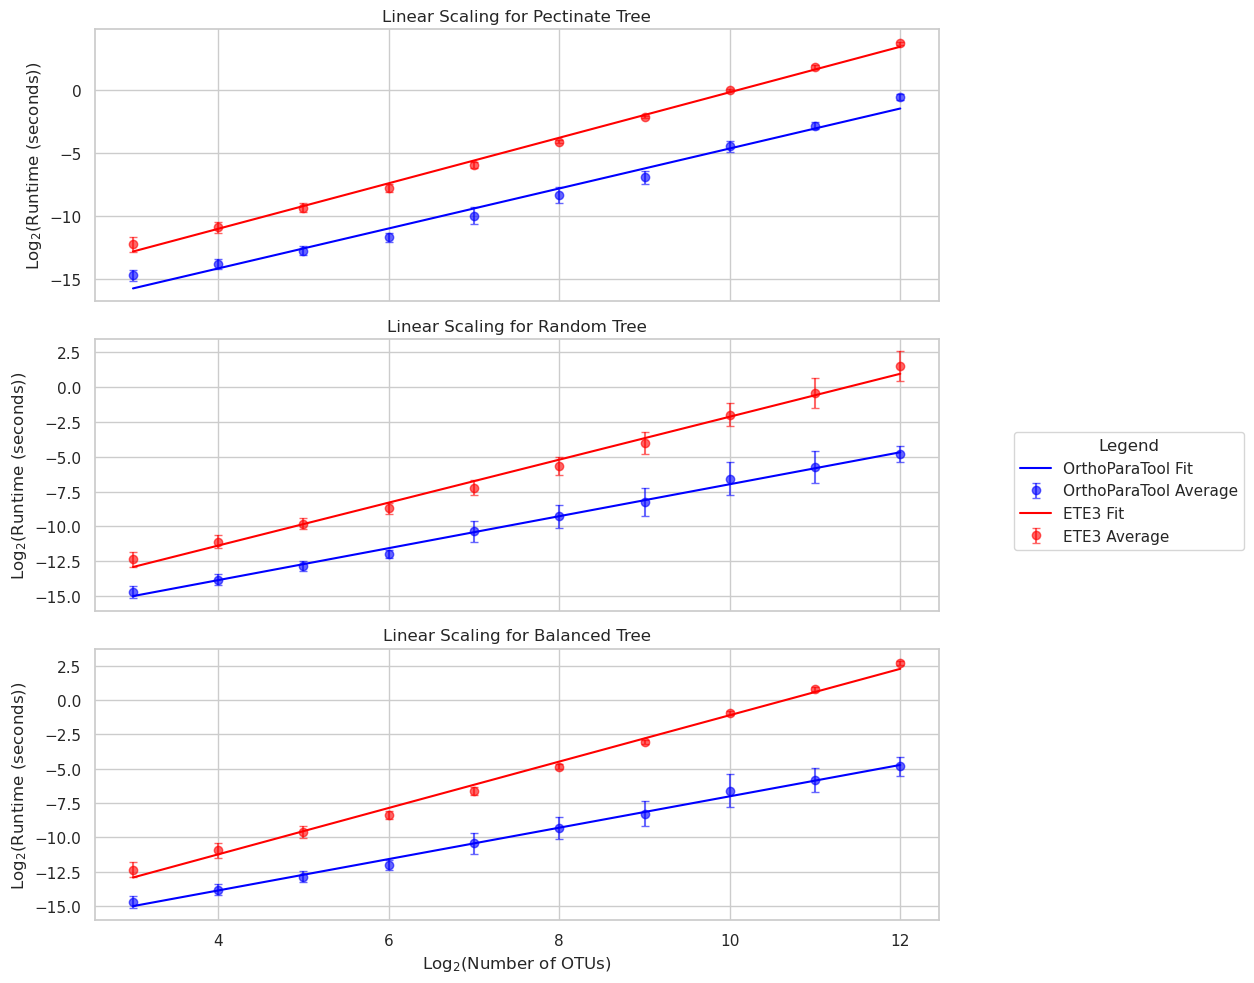

In [6]:
# Log2-transformation
df['log2_num_otus'] = np.log2(df['num_otus'])
df['log2_our_time'] = np.log2(df['our_time'])
df['log2_ete_time'] = np.log2(df['ete_time'])

# Group by both type and number of OTUs, and calculate mean and standard deviation
df_grouped = df.groupby(['type', 'num_otus']).agg({
    'log2_our_time': ['mean', 'std'],
    'log2_ete_time': ['mean', 'std'],
    'log2_num_otus': 'mean'
}).reset_index()


df_grouped.columns = ['type', 'num_otus', 'log2_our_time_mean', 'log2_our_time_std',
                      'log2_ete_time_mean', 'log2_ete_time_std', 'log2_num_otus']

# Linear regression
def linear_regression(df, time_column):
    X = sm.add_constant(df['log2_num_otus'])
    y = df[time_column]
    model = sm.OLS(y, X).fit()
    return model

# Subplots for each tree type
sns.set(style="whitegrid")
fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)  # Reduced height

# Style
colors = {'OrthoParaTool': 'blue', 'ETE3': 'red'}

# Define the order of subplots and map 'pectinate_right' to 'pectinate'
tree_order = ['pectinate_right', 'random', 'balanced']
tree_labels = {'pectinate_right': 'pectinate', 'random': 'random', 'balanced': 'balanced'}

# Loop over tree types to fit models and plot
for i, tree_type in enumerate(tree_order):
    ax = axs[i]
    df_subset = df_grouped[df_grouped['type'] == tree_type]

    # Fit linear models for both algorithms
    model_our = linear_regression(df_subset, 'log2_our_time_mean')
    model_ete = linear_regression(df_subset, 'log2_ete_time_mean')

    # Linear fit values
    x_vals = np.linspace(df_subset['log2_num_otus'].min(), df_subset['log2_num_otus'].max(), 100)
    X_pred = sm.add_constant(x_vals)
    y_our_pred = model_our.predict(X_pred)
    y_ete_pred = model_ete.predict(X_pred)

    # Plot linear fit
    line_our, = ax.plot(x_vals, y_our_pred, label=f'OrthoParaTool Fit', 
                        color=colors['OrthoParaTool'], linestyle='-')
    line_ete, = ax.plot(x_vals, y_ete_pred, label=f'ETE3 Fit', 
                        color=colors['ETE3'], linestyle='-')

    # Plot averages with error bars
    avg_our = ax.errorbar(df_subset['log2_num_otus'], df_subset['log2_our_time_mean'],
                          yerr=df_subset['log2_our_time_std'], fmt='o', 
                          label=f'OrthoParaTool Average', color=colors['OrthoParaTool'], 
                          alpha=0.6, capsize=3)
    avg_ete = ax.errorbar(df_subset['log2_num_otus'], df_subset['log2_ete_time_mean'],
                          yerr=df_subset['log2_ete_time_std'], fmt='o', 
                          label=f'ETE3 Average', color=colors['ETE3'], 
                          alpha=0.6, capsize=3)

    # Set title
    ax.set_title(f'Linear Scaling for {tree_labels[tree_type].capitalize()} Tree')
    ax.set_ylabel('Log$_{2}$(Runtime (seconds))')

# Labels and Legend
axs[-1].set_xlabel('Log$_{2}$(Number of OTUs)')


fig.legend([line_our, avg_our, line_ete, avg_ete], 
           ['OrthoParaTool Fit', 'OrthoParaTool Average', 'ETE3 Fit', 'ETE3 Average'], 
           loc='center left', bbox_to_anchor=(1, 0.5), title='Legend')

plt.tight_layout(rect=[0, 0, 0.95, 1])

plt.show()

In [7]:
for tree_type in tree_order:
    df_subset = df_grouped[df_grouped['type'] == tree_type]
    
    model_our = linear_regression(df_subset, 'log2_our_time_mean')
    model_ete = linear_regression(df_subset, 'log2_ete_time_mean')
    
    print(f"--- {tree_labels[tree_type].capitalize()} Tree ---")
    print("OrthoParaTool Linear Model Summary:")
    print(model_our.summary())
    
    print("\nETE3 Tool Linear Model Summary:")
    print(model_ete.summary())

--- Pectinate Tree ---
OrthoParaTool Linear Model Summary:
                            OLS Regression Results                            
Dep. Variable:     log2_our_time_mean   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     442.3
Date:                Fri, 20 Sep 2024   Prob (F-statistic):           2.74e-08
Time:                        20:26:26   Log-Likelihood:                -9.3394
No. Observations:                  10   AIC:                             22.68
Df Residuals:                       8   BIC:                             23.28
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

/home/davisoc/miniconda3/envs/orthoparatests/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  res = hypotest_fun_out(*samples, **kwds)
/home/davisoc/miniconda3/envs/orthoparatests/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  res = hypotest_fun_out(*samples, **kwds)
/home/davisoc/miniconda3/envs/orthoparatests/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  res = hypotest_fun_out(*samples, **kwds)
/home/davisoc/miniconda3/envs/orthoparatests/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  res = hypotest_fun_out(*samples, **kwds)
/home/davisoc/miniconda3/envs/orthoparatests/lib/python3.12/site-packages/scipy/stat